# TP 5 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [21]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [22]:
from functions import *

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
# Restauracion de Imagenes - Trabajo de investigacion

In [24]:
lena = Image.open('img/lena_gray.tif')

***
## 1 - Inverse Filtering
Dado que se conoce la PSF (transformada de Fourier del proceso de degradacion h(x,y)) podemos aplicar el filtro inverso:
\begin{equation*}
    R(\omega_x,\omega_y) = \dfrac{1}{H(\omega_x,\omega_y)}
\end{equation*}

### a - Blur
Obtenemos el efecto de borroso aplicando un filtro pasabajos gaussiano y luego aplicamos filtro inverso

MSE: 6.441707491095162e-15


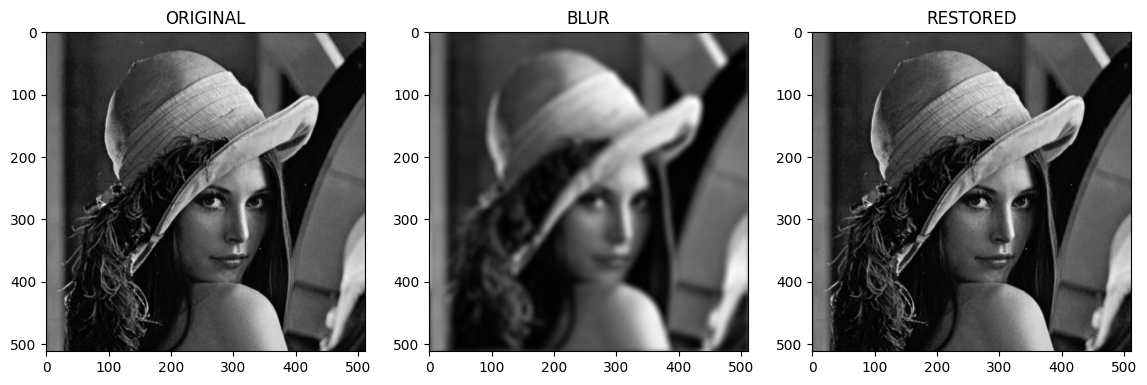

In [25]:
kernel = gaussian_kernel(size=15,sigma=5)
kernel = resize_kernel(lena.size,kernel)

img_blurd = apply_filter(lena,kernel)

restored = apply_inverse_filter(img_blurd,kernel)

images = {'ORIGINAL':lena,
          'BLUR':img_blurd,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

### b - Blur + Noise

MSE: 129590609610798.8


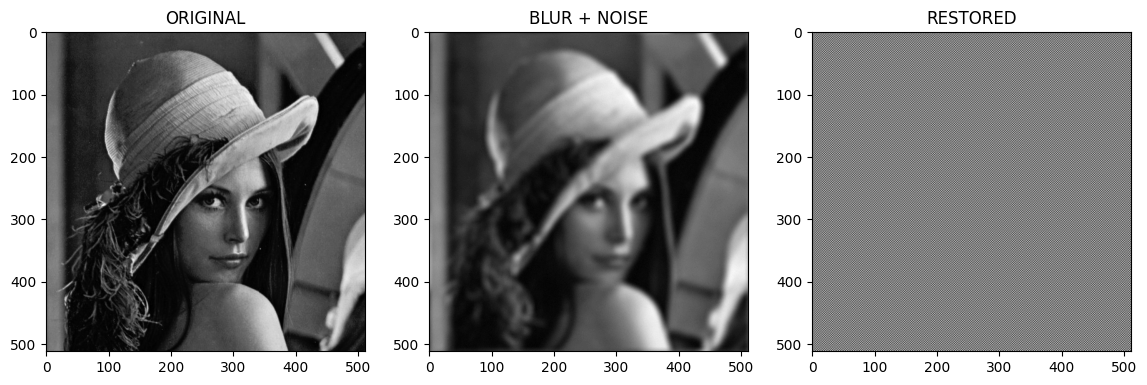

In [27]:
snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

restored = apply_inverse_filter(img_blurd_noisy,kernel)
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

***
## 2 - Wiener
Este filtro intenta resolver el problema de la amplificación del ruido buscando una solución de compromiso entre la calidad de la restauración y la amplificación del ruido. Suponiendo que la señal **s** y el ruido **n** son procesos aleatorios con media cero, si deseamos estimar la señal usando un estimador lineal:

\begin{equation*}
\hat{s}(x,y) = (s(x,y) + n(x,y))*h(x,y)
\end{equation*}

Entonces la ecuación del filtro de Wiener es:

\begin{equation*}
W(w_x,w_y) = \dfrac{H^*(w_x,w_y)S_{xx}(w_x,w_y)}{|H(w_x,w_y)|^2S_{xx}(w_x,w_y) + S_{nn}(w_x,w_y)}
\end{equation*}

Siendo $S_{xx}$ y $S_{nn}$ las densidades espectrales del ruido y H la respuesta en frecuencia del filtro degradador.

In [28]:
restored_wiener = apply_wiener_filter(lena, img_blurd_noisy, noise, kernel)

MSE: 78.25632498133014


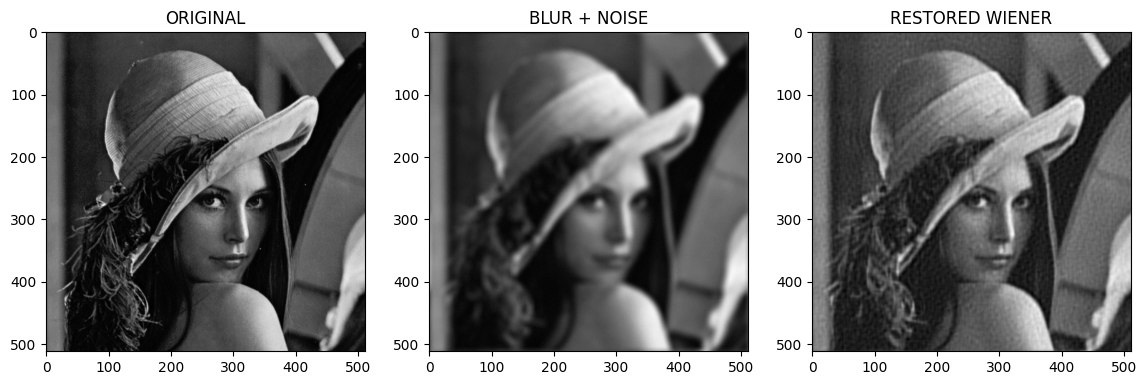

In [29]:
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED WIENER':restored_wiener
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED WIENER']).var())
compare(images)

***
## 3 - Blind deconvolution

Este metodo de restauracion aplica la deconvolución sin conocer de forma exacta la respuesta al impulso que genero la degradacion de la imagen. En general, se realizan suposiciones sobre la imagen original y dicha respuesta al impulso. 
En el caso analizado se aplica el efecto blur y ruido normal. En esta tecnica de restauracion se busca estimar la PSF desde la imagen borrosa.
Para esto se aplica el algoritmo iterativo de deconvolucion de Richardson-Lucy. Se logra apreciar en la imagen final un cierto grado de mejora en terminos de nitidez. 

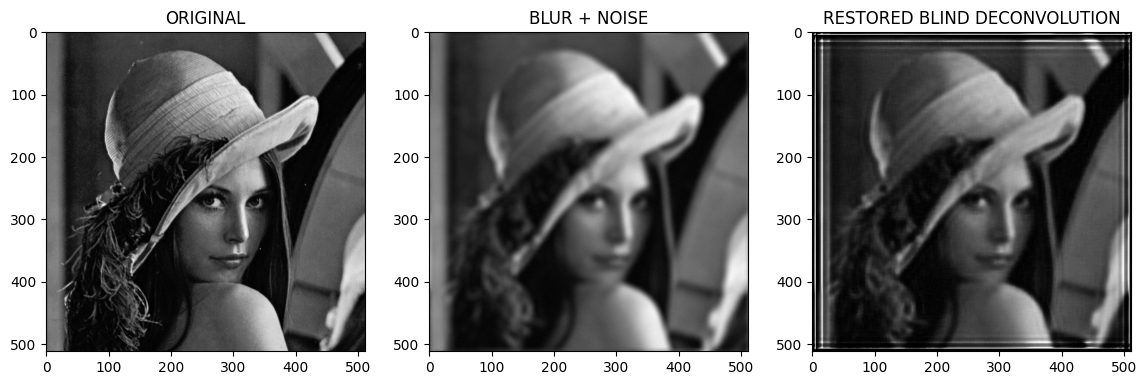

In [30]:
snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

n=10
kernel = np.full((n,n),1/n)
result = richardson_lucy(img_blurd_noisy.astype(np.float64)/255.0, kernel, num_iter=30)

images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED BLIND DECONVOLUTION':result}
compare(images)

***
## 4 - Motion Blur

El motion blur que se obtiene de la captura de una imagen o video se puede modelizar como una PSF. Esta PSF está compuesta por una linea del ángulo y largo de la dirección del blurring. Por ejemplo, si se tiene un motion blur de 9 pixeles de largo en un ángulo de 45°, la PSF será una linea de 9 pixeles de largo con un ángulo de 45°. Luego, conociendo la PSF, se puede cancelar el motion blur a traves de cualquier método que permita cancelar su efecto, como una deconvolución o un filtro de Wiener.

Con motion_kernel se puede generar una PSF que permita recrear el motion blur de una imagen.

Se aplica un motion blur de tamaño 30 y 30° a una imagen.

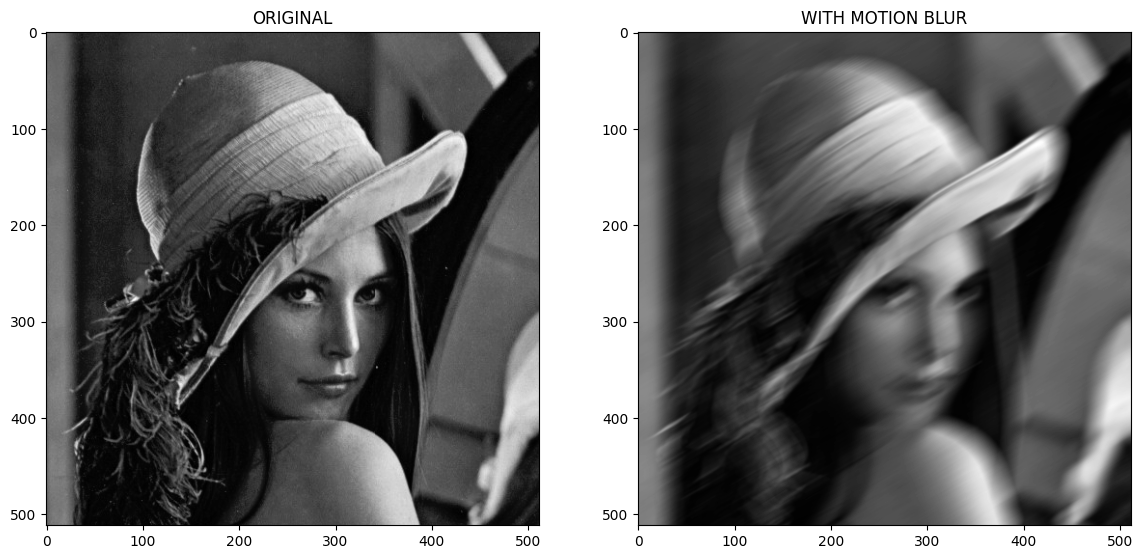

In [31]:
lena = cv2.imread('img/lena_gray.tif', cv2.IMREAD_GRAYSCALE)
kernel = motion_kernel(30, 30)
lena_motion_blur = cv2.filter2D(lena, -1, kernel)
images = {'ORIGINAL':lena,
          'WITH MOTION BLUR':lena_motion_blur}
compare(images)

Para quitar el motion blur, podemos aplicar un filtro de Weiner. El filtro de Weiner se comporta como un filtro inverso a la psf del motion blur, y a su vez minimiza el MSE.

362.7941690660456


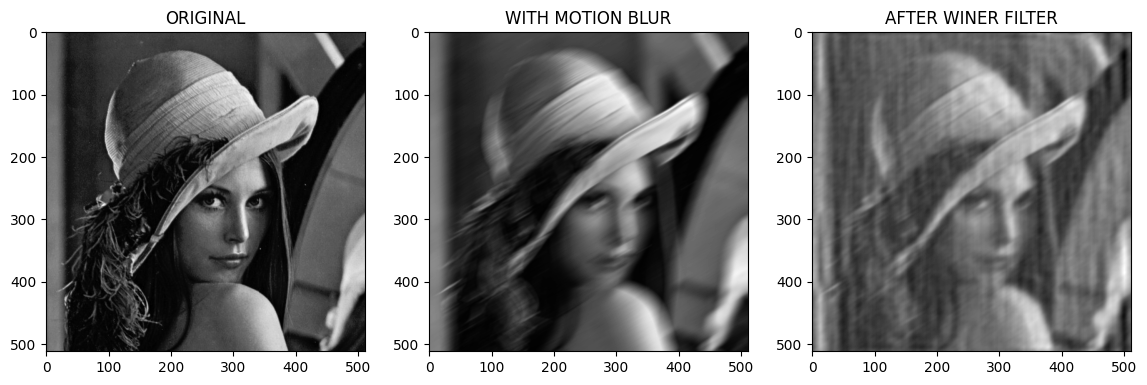

In [32]:
kernel = motion_kernel(30, 30, size=np.shape(lena)[0])
snr = 0.01
noise = normal_noise(lena, snr)

lena_filtered_motion = apply_wiener_filter(lena, lena_motion_blur, noise, kernel)

images = {'ORIGINAL':lena,
          'WITH MOTION BLUR': lena_motion_blur,
          'AFTER WINER FILTER':lena_filtered_motion}
mse = np.mean((lena - lena_filtered_motion)**2)
print(mse)
compare(images)

***
## 5 - Regularización y métodos iterativos

Usando el paper: "Regularized Iterative Image Restoration with Ringing Reduction", Reginald L. Lagendijk. A continuación vamos a ver la implementación de una regularización directa seguido del método iterativo. Para la regularización vimos que el valor de gamma elegido depende de la imágen y las condiciones de blur y ruido. Por otro lado para el método iterativo se ve como mejora la restauración con las iteraciones pero a partir de un orden se aleja del resultado deseado.

In [34]:
lena = Image.open('img/lena_gray.tif')

kernel = gaussian_kernel(size=15,sigma=5)
kernel = resize_kernel(lena.size,kernel)
img_blurd = apply_filter(lena,kernel)

snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

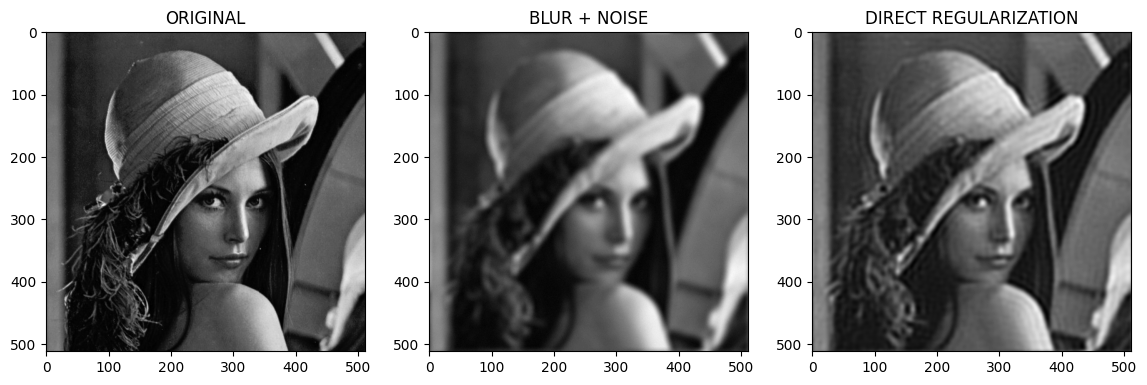

In [35]:
gamma = 0.064
result = restore_regularization(lena, img_blurd_noisy, kernel, gamma)

images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'DIRECT REGULARIZATION':result}
compare(images)

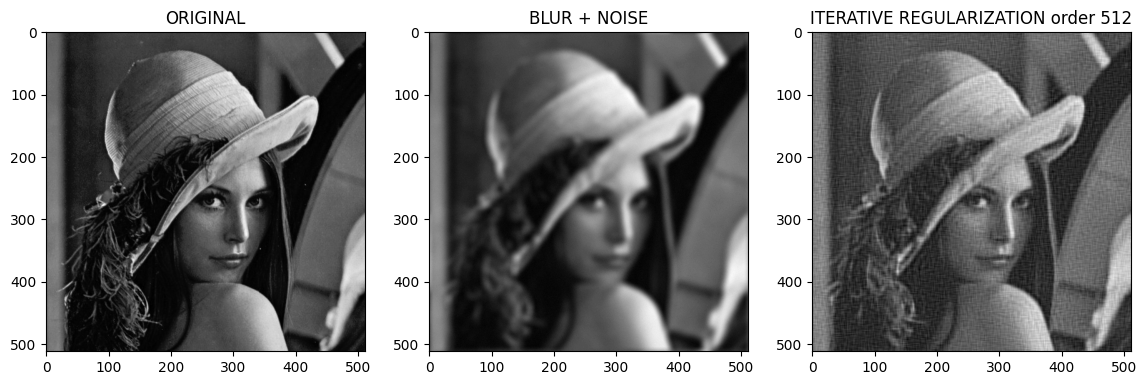

In [59]:
iterations = 2**9
result = reg_iter(img_blurd_noisy, kernel, iterations)

images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          f'ITERATIVE REGULARIZATION order {iterations}':result}
     
compare(images)

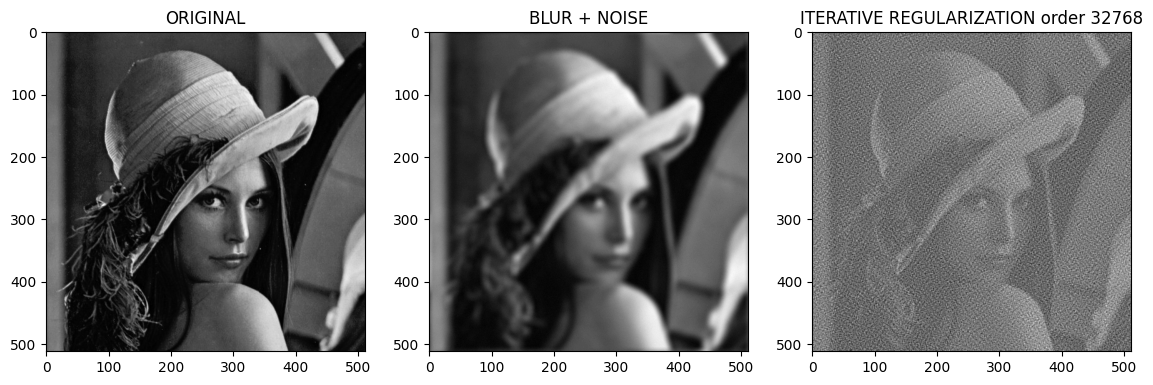

In [61]:
iterations = 2**15
result = reg_iter(img_blurd_noisy, kernel, iterations)

images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          f'ITERATIVE REGULARIZATION order {iterations}':result}
     
compare(images)

***
## Clown
Eliminar la interferencia de la siguiente imágen

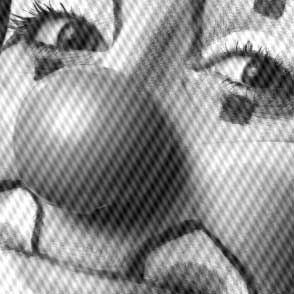

In [ ]:
clown = Image.open('img/clown.jpg')
w, h = clown.size
displayImage(clown, w, h)

Observamos el espectro de la imagen

In [ ]:
arr_clown = np.asarray(clown)[:,:,0]
A = 0.955   # Factor de atenuación para evitar error numérico por Wrap Around
arr_clown = arr_clown * A

Spect = fft.fft2(arr_clown)

ModSpect = abs(Spect)
IMd = np.log(1+ModSpect)
fig = px.imshow(fft.fftshift(IMd/np.max(IMd)))
# fig = px.imshow(IMd/np.max(IMd))
fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Brickwall notch (= 0)
filtered_1 = fft.fftshift(Spect).copy()

D1 = 50
D2 = 20

for i in range(w):
    for j in range(h):
        if (distance(i, j, 172, 105) <  D1):
            filtered_1[i, j] = 0
        elif (distance(i, j, 122, 189) <  D1):
            filtered_1[i, j] = 0
        elif (distance(i, j, 160, 169) <  D2):
            filtered_1[i, j] = 0
        elif (distance(i, j, 136, 127) <  D2):
            filtered_1[i, j] = 0

IMd = np.log(1+abs(filtered_1))
fig = px.imshow(IMd/np.max(IMd))
fig.update_layout(width=400, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.show()

filtered_1_clown = abs(fft.ifft2(fft.fftshift(filtered_1)))
displayImage_fromcv2(filtered_1_clown, w, h)